# **SRCNN Tutorial**
In this tutorial, you will learn how to use SRCNN [1] to perform single image super-resolution. Throughout the tutorial, we will use MMEditing to

*   perform inference with SRCNN
*   finetune SRCNN on a customized dataset

Let's start!

$\quad$

[1] Dong *et al.*, Image Super-Resolution Using Deep Convolutional Networks, TPAMI, 2015.


## **Background**

Let's begin with a recap of the background of super-resolution. 
 
$\quad$

The objective of single image super-resolution (SR) is to recover a high-resolution (HR) image given a low-resolution (LR) image. 

Mathematically, we can model the image degradation process using the following formulation:

\begin{equation}
\mathbf{y} = DK\mathbf{x} + \mathbf{n}.\qquad \text{(1)}
\end{equation}

Here, $\mathbf{x}$ and $\mathbf{y}$ denote the HR and LR images (in vector form), respectively. $D$, $K$, and $\mathbf{n}$ correspond to the downsampling and blurring matrices, and addictive noise, respectively.

Our goal is to reconstruct a HR image $\mathbf{x}$ given the LR image $\mathbf{y}$. In this tutorial, we assume $D$ and $K$ are known, and $\mathbf{n}=0$. 

$\quad$

Now, let's learn how to use MMEditing for SR.

## **Install MMEditing**

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Install dependencies
!pip install cython mmcv

# Install MMEditing
!rm -rf mmediting
!git clone https://github.com/open-mmlab/mmediting.git
%cd mmediting
!pip install -r requirements.txt
!pip install -v -e .

     |████████████████████████████████| 245kB 2.7MB/s 
     |████████████████████████████████| 194kB 8.2MB/s 
  Created wheel for mmcv: filename=mmcv-1.1.4-cp36-cp36m-linux_x86_64.whl size=400604 sha256=46547be6724c1e78547e990205e9391d0dad03a20832b191da847630a4f20739
  Stored in directory: /root/.cache/pip/wheels/64/83/ac/da1fe61176c01af5f6cbade5371686c79e49fdf1565bb5152d
Successfully built mmcv
Cloning into 'mmediting'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 4676 (delta 15), reused 25 (delta 7), pack-reused 4618
Receiving objects: 100% (4676/4676), 3.59 MiB | 802.00 KiB/s, done.
Resolving deltas: 100% (3206/3206), done.
/content/mmediting
     |████████████████████████████████| 245kB 2.7MB/s 
     |████████████████████████████████| 81kB 4.2MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
  Using cached https://files.pythonhosted.org/packages/16/45/81b5262c0efc08882

In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMEditing installation
import mmedit
print(mmedit.__version__)

1.6.0+cu101 True
0.5.0


## **Perform Inference with A Pre-trained SRCNN**


### **Download checkpoints and images**


In [ ]:
# Download the pre-trained models
!rm -rf checkpoint
!mkdir checkpoint
!wget -c https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/restorers/srcnn/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth \
      -O ./checkpoint/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth

# Download the training and test datasets for later use
!rm -rf ./data
!git clone https://github.com/kckchan-dev/Datasets.git data

--2020-10-01 06:15:27--  https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/restorers/srcnn/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth
Resolving openmmlab.oss-accelerate.aliyuncs.com (openmmlab.oss-accelerate.aliyuncs.com)... 47.88.36.78
Connecting to openmmlab.oss-accelerate.aliyuncs.com (openmmlab.oss-accelerate.aliyuncs.com)|47.88.36.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85911 (84K) [application/octet-stream]
Saving to: ‘./checkpoint/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth’

./checkpoint/srcnn_ 100%[===================>]  83.90K  --.-KB/s    in 0.05s   

2020-10-01 06:15:28 (1.74 MB/s) - ‘./checkpoint/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth’ saved [85911/85911]

Cloning into 'data'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 225 (delta 5), reused 217 (delta 0), pack-reused 0
Receiving objects: 100

### **Inference**

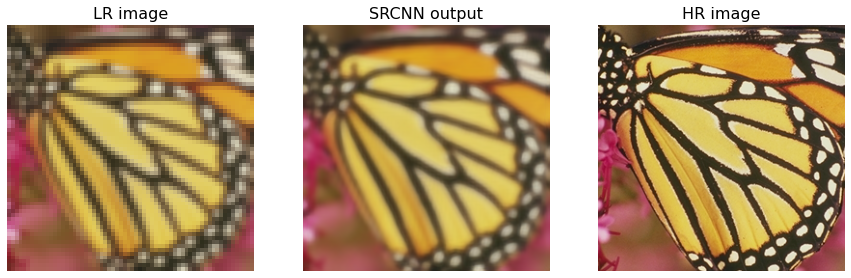

In [ ]:
import cv2
import matplotlib.pyplot as plt
import mmcv
import torch
import torchvision

from mmedit.models import build_model
from mmcv.runner import load_checkpoint

# Build model
cfg = mmcv.Config.fromfile('configs/restorers/srcnn/srcnn_x4k915_g1_1000k_div2k.py')
model = build_model(cfg.model).cuda()
load_checkpoint(model, './checkpoint/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth', map_location='cuda')

# Read the images
img_LR = mmcv.imread('./data/Set5/LR/butterfly.png', channel_order='rgb')
img_HR = mmcv.imread('./data/Set5/GT/butterfly.png', channel_order='rgb')

# Cast the input image as a PyTorch FloatTensor
img_SR = torch.from_numpy(img_LR).cuda().float().permute(2, 0, 1).unsqueeze(0)
img_SR = img_SR / 255  # Input range = [0, 1]

# Compute the output and cast it back to a numpy array
with torch.no_grad():
  img_SR = model.forward_test(img_SR)['output']
img_SR = torch.clamp(img_SR, 0, 1)  # Output range = [0, 1]
img_SR = img_SR.squeeze(0).permute(1, 2, 0).numpy()

# Let's compare the result with the LR and HR images
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(1, 3, 1)  # 1 row, 3 columns, the top left image  
plt.title('LR image', fontsize=16)
ax1.axis('off')
ax2 = fig.add_subplot(1, 3, 2)  # 2 row, 3 columns, the top right image 
plt.title('SRCNN output', fontsize=16)
ax2.axis('off')
ax3 = fig.add_subplot(1, 3, 3)  # 2 row, 3 columns, the bottom right image  
plt.title('HR image', fontsize=16)
ax3.axis('off')
ax1.imshow(img_LR)
ax2.imshow(img_SR)
ax3.imshow(img_HR)

The output is much better than the LR input! But it is still a bit blurry, why is that? We will tell you the reason later.

### **Filter Visualization**

SRCNN is a convolutional neural network. That means, each layer consists of multiple *convolution filters*. You may wonder what the learned filters are. Is there any relation between the learned filters and the hand-designed filters, such as Sobel filter, Gaussian filter, etc.? Here, we visualize the filters of the first layer to provide an intuition. This layer directly operates on the input image.

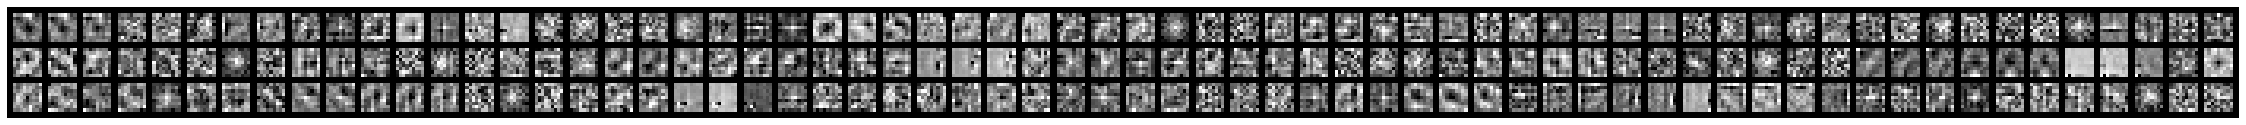

In [ ]:
import mmcv
import torchvision
from mmedit.models import build_model
from mmcv.runner import load_checkpoint

cfg = mmcv.Config.fromfile('configs/restorers/srcnn/srcnn_x4k915_g1_1000k_div2k.py')
model = build_model(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)
load_checkpoint(model, './checkpoint/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth', map_location='cpu')
conv1_weight = model.generator.conv1.weight.detach()
n_out, n_in, h, w = conv1_weight.size()
conv1_weight = conv1_weight.view(-1, 1, h, w)
grid_img = torchvision.utils.make_grid(conv1_weight, normalize=True, scale_each=True, nrow=64)
fig = plt.figure(figsize=(40, 30))
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))


We can see that the learned fitlers are diverse. For example, we can see both isotropic (uniform in all directions) and anisotropic (directional) filters. The outputs of these filters are then fed to the next layer.

While it is easy to interpret the meaning (e.g. edge detection, blurring) of the filters when they are applied to the image, when going deeper, the filters become non-interpretable.

### **Blurring kernel**

As we discussed, the above output is still blurry. Why is that?

$\quad$

The performance of SRCNN (and many other data-driven methods) strongly depends on the training data. When the training data and test data have different distributions, the performance of such methods deteriorate significantly. In fact, the SRCNN we used above is trained with no blurring ($K=I$), but the input test image is blurred by a Gaussian kernel before downsampling. 

$\quad$

In order to improve the output quality, we should train a model using the same degradations. In the following, we will now finetune our pre-trained SRCNN using the sampling degradations. You will learn how to use MMEditing to train a restorer on a customized dataset.

## **Finetune SRCNN on A Customized Dataset**

To train a new restorer using MMEditing, there are usually three things to do:

1.   Support a new dataset
2.   Modify the config
3.   Train a new restorer

### **Support a new dataset**

To support a new dataset for paired training, there are two things you need to prepare.

1. Download the LR images and the corresponding HR images. They share the same file name but are put in different directories.

2. Create an annotation file for your dataset. The annoataion file contains all the image names and gt image shape. For example:

```
0001_s001.png (480,480,3)
0001_s002.png (480,480,3)
...
```

As an example, we will use a tiny dataset obtained from DIV2K. Let's create the annotation file for this training data.


In [ ]:
import glob
gt_paths = sorted(glob.glob('./data/DIV2K/GT/*.png'))
with open('data/training_ann.txt', 'w') as f:
  for gt_path in gt_paths:
    filename = gt_path.split('/')[-1]
    line = f'{filename} (480,480,3)\n'
    f.write(line)

# Let's make sure the annotations are correct
with open('data/training_ann.txt', 'r') as f:
  file_content = f.read()
  print(file_content)

0003_s019.png (480,480,3)
0004_s040.png (480,480,3)
0009_s045.png (480,480,3)
0010_s034.png (480,480,3)
0026_s016.png (480,480,3)
0028_s047.png (480,480,3)
0032_s028.png (480,480,3)
0044_s053.png (480,480,3)
0056_s035.png (480,480,3)
0066_s029.png (480,480,3)
0072_s021.png (480,480,3)
0074_s004.png (480,480,3)
0089_s012.png (480,480,3)
0093_s022.png (480,480,3)
0104_s013.png (480,480,3)
0119_s020.png (480,480,3)
0130_s018.png (480,480,3)
0130_s024.png (480,480,3)
0132_s021.png (480,480,3)
0147_s031.png (480,480,3)
0163_s032.png (480,480,3)
0174_s028.png (480,480,3)
0174_s036.png (480,480,3)
0175_s015.png (480,480,3)
0184_s011.png (480,480,3)
0191_s032.png (480,480,3)
0213_s022.png (480,480,3)
0216_s019.png (480,480,3)
0219_s006.png (480,480,3)
0226_s001.png (480,480,3)
0228_s015.png (480,480,3)
0231_s020.png (480,480,3)
0238_s009.png (480,480,3)
0260_s011.png (480,480,3)
0261_s002.png (480,480,3)
0268_s012.png (480,480,3)
0275_s009.png (480,480,3)
0280_s003.png (480,480,3)
0301_s012.pn

### **Modify the configuration file**

The next step is to modify the configuration file for training. In this tutorial, we finetune a pre-trained restorer to accelerate the process.

In [ ]:
from mmcv import Config
# Load the original config
cfg = Config.fromfile('configs/restorers/srcnn/srcnn_x4k915_g1_1000k_div2k.py')

print(f'Config:\n{cfg.pretty_text}')  # Show the config

Config:
exp_name = 'srcnn_x4k915_g1_1000k_div2k'
scale = 4
model = dict(
    type='BasicRestorer',
    generator=dict(
        type='SRCNN',
        channels=(3, 64, 32, 3),
        kernel_sizes=(9, 1, 5),
        upscale_factor=4),
    pixel_loss=dict(type='L1Loss', loss_weight=1.0, reduction='mean'))
train_cfg = None
test_cfg = dict(metrics=['PSNR', 'SSIM'], crop_border=4)
train_dataset_type = 'SRAnnotationDataset'
val_dataset_type = 'SRFolderDataset'
train_pipeline = [
    dict(
        type='LoadImageFromFile',
        io_backend='disk',
        key='lq',
        flag='unchanged'),
    dict(
        type='LoadImageFromFile',
        io_backend='disk',
        key='gt',
        flag='unchanged'),
    dict(type='RescaleToZeroOne', keys=['lq', 'gt']),
    dict(
        type='Normalize',
        keys=['lq', 'gt'],
        mean=[0, 0, 0],
        std=[1, 1, 1],
        to_rgb=True),
    dict(type='PairedRandomCrop', gt_patch_size=128),
    dict(
        type='Flip', keys=['lq', 'gt'], f

Given a configuration that trains a model on the whole DIV2K, we need to modify the configuration so that it trains on our tiny dataset.

In [ ]:
from mmcv.runner import set_random_seed

# Training folders
cfg.data.train.dataset.lq_folder = './data/DIV2K/LR'
cfg.data.train.dataset.gt_folder = './data/DIV2K/GT'
cfg.data.train.dataset.ann_file = './data/training_ann.txt'

# Validation folders
cfg.data.val.lq_folder = './data/Set5/LR'
cfg.data.val.gt_folder = './data/Set5/GT'

# Test folders
cfg.data.test.lq_folder = './data/Set5/LR'
cfg.data.test.gt_folder = './data/Set5/GT'

# Use the pre-trained SRCNN model
cfg.load_from = './checkpoint/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth'

# Set up working dir to save files and logs
cfg.work_dir = './tutorial_exps/srcnn'

# Use smaller batch size for training
cfg.data.samples_per_gpu = 4
cfg.data.workers_per_gpu = 0
cfg.data.val_workers_per_gpu = 0

# Reduce the number of iterations
cfg.total_iters = 200

# Training scheme
cfg.lr_config = {}
cfg.lr_config.policy = 'Step'
cfg.lr_config.by_epoch = False
cfg.lr_config.step = [100]
cfg.lr_config.gamma = 0.5

# Evaluate every 20 iterations
cfg.evaluation.interval = 20
if cfg.evaluation.get('gpu_collect', None):
  cfg.evaluation.pop('gpu_collect')

# Save the checkpoints every N iterations
cfg.checkpoint_config.interval = 20

# Print out the log every N iterations
cfg.log_config.interval = 5

# Set seed thus the results are reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpus = 1

### **Train**

FInally, let's initialize the dataset and restorer, and train a new restorer!

In [ ]:
import os.path as osp

from mmedit.datasets import build_dataset
from mmedit.models import build_model
from mmedit.apis import train_model
from mmcv.runner import init_dist

import mmcv
import os

# Initialize distributed training (only need to initialize once), comment it if
# have already run this part
os.environ['RANK'] = '0'
os.environ['WORLD_SIZE'] = '1'
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '50297'
init_dist('pytorch', **cfg.dist_params)


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the SRCNN model
model = build_model(
        cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# Meta information
meta = dict()
if cfg.get('exp_name', None) is None:
    cfg['exp_name'] = osp.splitext(osp.basename(cfg.work_dir))[0]
meta['exp_name'] = cfg.exp_name
meta['mmedit Version'] = mmedit.__version__
meta['seed'] = 0

# Train the model
train_model(model, datasets, cfg, distributed=True, validate=True, meta=meta)


2020-10-01 06:20:24,457 - mmedit - INFO - load checkpoint from ./checkpoint/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth
2020-10-01 06:20:24,460 - mmedit - INFO - Start running, host: root@9f233705434c, work_dir: /content/mmediting/tutorial_exps/srcnn
2020-10-01 06:20:24,463 - mmedit - INFO - workflow: [('train', 1)], max: 200 iters
2020-10-01 06:20:30,094 - mmedit - INFO - Iter [5/200]	lr_generator: 2.000e-04, eta: 0:02:45, time: 0.847, data_time: 0.000, memory: 58, loss_pix: 0.0421, loss: 0.0421
2020-10-01 06:20:30,408 - mmedit - INFO - Iter [10/200]	lr_generator: 2.000e-04, eta: 0:01:26, time: 0.063, data_time: 0.003, memory: 58, loss_pix: 0.0460, loss: 0.0460
2020-10-01 06:20:30,712 - mmedit - INFO - Iter [15/200]	lr_generator: 2.000e-04, eta: 0:00:59, time: 0.061, data_time: 0.002, memory: 58, loss_pix: 0.0411, loss: 0.0411
2020-10-01 06:20:31,016 - mmedit - INFO - Saving checkpoint at 20 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 11.9 task/s, elapsed: 0s, ETA:     0s

2020-10-01 06:20:31,451 - mmedit - INFO - Iter(val) [20]	PSNR: 25.4640, SSIM: 0.7017


2020-10-01 06:20:31,757 - mmedit - INFO - Iter [25/200]	lr_generator: 2.000e-04, eta: 0:00:39, time: 0.144, data_time: 0.086, memory: 134, loss_pix: 0.0410, loss: 0.0410
2020-10-01 06:20:32,067 - mmedit - INFO - Iter [30/200]	lr_generator: 2.000e-04, eta: 0:00:33, time: 0.062, data_time: 0.002, memory: 134, loss_pix: 0.0478, loss: 0.0478
2020-10-01 06:20:32,382 - mmedit - INFO - Iter [35/200]	lr_generator: 2.000e-04, eta: 0:00:29, time: 0.063, data_time: 0.002, memory: 134, loss_pix: 0.0388, loss: 0.0388
2020-10-01 06:20:32,676 - mmedit - INFO - Saving checkpoint at 40 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.2 task/s, elapsed: 0s, ETA:     0s

2020-10-01 06:20:33,098 - mmedit - INFO - Iter(val) [40]	PSNR: 25.4500, SSIM: 0.7094


2020-10-01 06:20:33,430 - mmedit - INFO - Iter [45/200]	lr_generator: 2.000e-04, eta: 0:00:23, time: 0.147, data_time: 0.083, memory: 134, loss_pix: 0.0393, loss: 0.0393
2020-10-01 06:20:33,758 - mmedit - INFO - Iter [50/200]	lr_generator: 2.000e-04, eta: 0:00:21, time: 0.065, data_time: 0.002, memory: 134, loss_pix: 0.0363, loss: 0.0363
2020-10-01 06:20:34,082 - mmedit - INFO - Iter [55/200]	lr_generator: 2.000e-04, eta: 0:00:20, time: 0.065, data_time: 0.002, memory: 134, loss_pix: 0.0411, loss: 0.0411
2020-10-01 06:20:34,389 - mmedit - INFO - Saving checkpoint at 60 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.1 task/s, elapsed: 0s, ETA:     0s

2020-10-01 06:20:34,784 - mmedit - INFO - Iter(val) [60]	PSNR: 25.7764, SSIM: 0.7140


2020-10-01 06:20:35,103 - mmedit - INFO - Iter [65/200]	lr_generator: 2.000e-04, eta: 0:00:17, time: 0.139, data_time: 0.077, memory: 134, loss_pix: 0.0418, loss: 0.0418
2020-10-01 06:20:35,422 - mmedit - INFO - Iter [70/200]	lr_generator: 2.000e-04, eta: 0:00:15, time: 0.064, data_time: 0.002, memory: 134, loss_pix: 0.0256, loss: 0.0256
2020-10-01 06:20:35,762 - mmedit - INFO - Iter [75/200]	lr_generator: 2.000e-04, eta: 0:00:14, time: 0.068, data_time: 0.002, memory: 134, loss_pix: 0.0350, loss: 0.0350
2020-10-01 06:20:36,066 - mmedit - INFO - Saving checkpoint at 80 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.6 task/s, elapsed: 0s, ETA:     0s

2020-10-01 06:20:36,475 - mmedit - INFO - Iter(val) [80]	PSNR: 25.8303, SSIM: 0.7160


2020-10-01 06:20:36,788 - mmedit - INFO - Iter [85/200]	lr_generator: 2.000e-04, eta: 0:00:13, time: 0.141, data_time: 0.081, memory: 134, loss_pix: 0.0294, loss: 0.0294
2020-10-01 06:20:37,109 - mmedit - INFO - Iter [90/200]	lr_generator: 2.000e-04, eta: 0:00:12, time: 0.064, data_time: 0.002, memory: 134, loss_pix: 0.0317, loss: 0.0317
2020-10-01 06:20:37,436 - mmedit - INFO - Iter [95/200]	lr_generator: 2.000e-04, eta: 0:00:11, time: 0.066, data_time: 0.002, memory: 134, loss_pix: 0.0352, loss: 0.0352
2020-10-01 06:20:37,737 - mmedit - INFO - Saving checkpoint at 100 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 13.0 task/s, elapsed: 0s, ETA:     0s

2020-10-01 06:20:38,137 - mmedit - INFO - Iter(val) [100]	PSNR: 25.7792, SSIM: 0.7176


2020-10-01 06:20:38,450 - mmedit - INFO - Iter [105/200]	lr_generator: 1.000e-04, eta: 0:00:09, time: 0.139, data_time: 0.078, memory: 134, loss_pix: 0.0366, loss: 0.0366
2020-10-01 06:20:38,752 - mmedit - INFO - Iter [110/200]	lr_generator: 1.000e-04, eta: 0:00:09, time: 0.060, data_time: 0.002, memory: 134, loss_pix: 0.0382, loss: 0.0382
2020-10-01 06:20:39,068 - mmedit - INFO - Iter [115/200]	lr_generator: 1.000e-04, eta: 0:00:08, time: 0.063, data_time: 0.002, memory: 134, loss_pix: 0.0355, loss: 0.0355
2020-10-01 06:20:39,374 - mmedit - INFO - Saving checkpoint at 120 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.7 task/s, elapsed: 0s, ETA:     0s

2020-10-01 06:20:39,782 - mmedit - INFO - Iter(val) [120]	PSNR: 25.8778, SSIM: 0.7193


2020-10-01 06:20:40,106 - mmedit - INFO - Iter [125/200]	lr_generator: 1.000e-04, eta: 0:00:07, time: 0.142, data_time: 0.080, memory: 134, loss_pix: 0.0288, loss: 0.0288
2020-10-01 06:20:40,425 - mmedit - INFO - Iter [130/200]	lr_generator: 1.000e-04, eta: 0:00:06, time: 0.064, data_time: 0.003, memory: 134, loss_pix: 0.0289, loss: 0.0289
2020-10-01 06:20:40,744 - mmedit - INFO - Iter [135/200]	lr_generator: 1.000e-04, eta: 0:00:06, time: 0.064, data_time: 0.002, memory: 134, loss_pix: 0.0298, loss: 0.0298
2020-10-01 06:20:41,047 - mmedit - INFO - Saving checkpoint at 140 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.9 task/s, elapsed: 0s, ETA:     0s

2020-10-01 06:20:41,448 - mmedit - INFO - Iter(val) [140]	PSNR: 25.8864, SSIM: 0.7174


2020-10-01 06:20:41,764 - mmedit - INFO - Iter [145/200]	lr_generator: 1.000e-04, eta: 0:00:05, time: 0.140, data_time: 0.079, memory: 134, loss_pix: 0.0418, loss: 0.0418
2020-10-01 06:20:42,072 - mmedit - INFO - Iter [150/200]	lr_generator: 1.000e-04, eta: 0:00:04, time: 0.062, data_time: 0.002, memory: 134, loss_pix: 0.0386, loss: 0.0386
2020-10-01 06:20:42,389 - mmedit - INFO - Iter [155/200]	lr_generator: 1.000e-04, eta: 0:00:04, time: 0.063, data_time: 0.002, memory: 134, loss_pix: 0.0356, loss: 0.0356
2020-10-01 06:20:42,689 - mmedit - INFO - Saving checkpoint at 160 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.7 task/s, elapsed: 0s, ETA:     0s

2020-10-01 06:20:43,099 - mmedit - INFO - Iter(val) [160]	PSNR: 25.9875, SSIM: 0.7192


2020-10-01 06:20:43,414 - mmedit - INFO - Iter [165/200]	lr_generator: 1.000e-04, eta: 0:00:03, time: 0.141, data_time: 0.080, memory: 134, loss_pix: 0.0337, loss: 0.0337
2020-10-01 06:20:43,735 - mmedit - INFO - Iter [170/200]	lr_generator: 1.000e-04, eta: 0:00:02, time: 0.064, data_time: 0.002, memory: 134, loss_pix: 0.0346, loss: 0.0346
2020-10-01 06:20:44,044 - mmedit - INFO - Iter [175/200]	lr_generator: 1.000e-04, eta: 0:00:02, time: 0.062, data_time: 0.002, memory: 134, loss_pix: 0.0362, loss: 0.0362
2020-10-01 06:20:44,352 - mmedit - INFO - Saving checkpoint at 180 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.9 task/s, elapsed: 0s, ETA:     0s

2020-10-01 06:20:44,755 - mmedit - INFO - Iter(val) [180]	PSNR: 25.9552, SSIM: 0.7179


2020-10-01 06:20:45,074 - mmedit - INFO - Iter [185/200]	lr_generator: 1.000e-04, eta: 0:00:01, time: 0.141, data_time: 0.079, memory: 134, loss_pix: 0.0417, loss: 0.0417
2020-10-01 06:20:45,396 - mmedit - INFO - Iter [190/200]	lr_generator: 1.000e-04, eta: 0:00:00, time: 0.065, data_time: 0.002, memory: 134, loss_pix: 0.0333, loss: 0.0333
2020-10-01 06:20:45,715 - mmedit - INFO - Iter [195/200]	lr_generator: 1.000e-04, eta: 0:00:00, time: 0.064, data_time: 0.002, memory: 134, loss_pix: 0.0433, loss: 0.0433
2020-10-01 06:20:46,044 - mmedit - INFO - Saving checkpoint at 200 iterations


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.8 task/s, elapsed: 0s, ETA:     0s

2020-10-01 06:20:46,449 - mmedit - INFO - Iter(val) [200]	PSNR: 25.9744, SSIM: 0.7202


### **Understand the log**

From the log, we can have a basic understanding on the training process and know how well the restorer is trained.

Firstly, the SRCNN pre-trained on DIV2K using bicubic downsampling kernel is loaded. During training you can keep track on the training status, including the current iteration, learning rate, losses, and time per iteration. 

$\quad$

Also, evaluation will be done from time to time. From the log we can see that the PSNR keeps increasing, up to 25.9744 dB in just 100 iterations. Here PSNR and SSIM are metrics measuring the "fidelity" of the output to the groundtruth. Higher values indicate better results.

Not bad!

### **Test the finetuned SRCNN**

In [ ]:
from mmedit.apis import single_gpu_test
from mmedit.datasets import build_dataloader
from mmcv.parallel import MMDataParallel


# Build a test dataloader and model
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])

# Perform the test with single gpu. Saving result images by setting
# save_image and save_path arguments. The two arguments will be passed
# to model.forword_test() where images are saved.
# See https://github.com/open-mmlab/mmediting/blob/8b5c0c5f49e60fd6ab0503031b62dee7832faf72/mmedit/models/mattors/indexnet.py#L72.
outputs = single_gpu_test(model, data_loader, save_image=True,
                          save_path='./tutorial_exps/srcnn/results')

# Pop out some unnecessary arguments
eval_config = cfg.evaluation
eval_config.pop('interval')
eval_config.pop('save_image', False)
eval_config.pop('save_path', None)

eval_res = dataset.evaluate(outputs, **eval_config)
print()  # endline of progress bar
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5/5, 12.2 task/s, elapsed: 0s, ETA:     0s
PSNR: 25.9744
SSIM: 0.7202


The result is the same as the last validation! This is because we use the same data for test and validation. Next, let's take a look at the visual results of the test! The results are saved in the directory tutorial_exps/srcnn/results that we specified.

In [ ]:
!ls tutorial_exps/srcnn/results

baby.png  bird.png  butterfly.png  head.png  woman.png


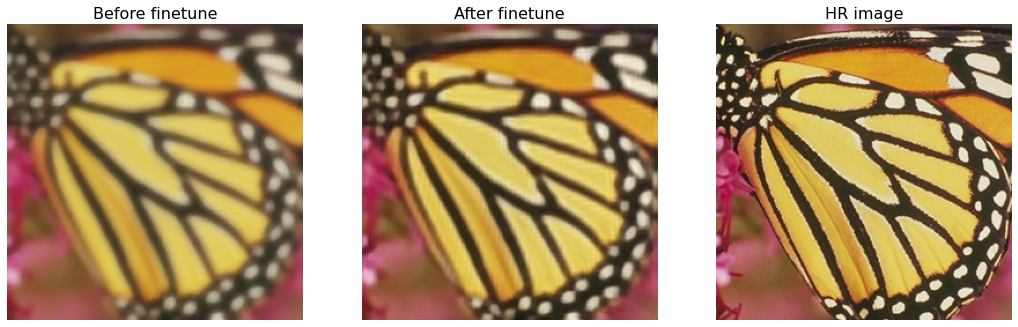

In [ ]:
import cv2
import matplotlib.pyplot as plt
import mmcv
import torch
import torchvision

from mmedit.models import build_model
from mmcv.runner import load_checkpoint

# Read the images
img_SR_ft = mmcv.imread('./tutorial_exps/srcnn/results/butterfly.png', channel_order='rgb')



# Let's compare the result with the LR and HR images
fig = plt.figure(figsize=(18, 16))
ax1 = fig.add_subplot(1, 3, 1)  # 2 rows, 2 columns, the top left image  
plt.title('Before finetune', fontsize=16)
ax1.axis('off')
ax2 = fig.add_subplot(1, 3, 2)  # 2 rows, 2 columns, the top right image 
plt.title('After finetune', fontsize=16)
ax2.axis('off')
ax3 = fig.add_subplot(1, 3, 3)  # 2 rows, 2 columns, the bottom right image  
plt.title('HR image', fontsize=16)
ax3.axis('off')
ax1.imshow(img_SR)
ax2.imshow(img_SR_ft)
ax3.imshow(img_HR)

## What to Do Next?

Single image super-resolution is just a part of the super-resolution family. There are more waiting for you to explore. For example, you can take a look at the following works:

1. Video super-resolution - [EDVR](https://arxiv.org/abs/1905.02716)
2. Reference-based image super-resolution - [SRNTT](https://arxiv.org/abs/1903.00834)

Enjoy!